# Importing the Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and classes
import pandas as pd
import numpy as np
import cv2
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import  MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
import pickle
import os
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Lambda, Activation, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from Attention import attention #importing attention layer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Exploring the Dataset

In [3]:
#define global variabels
X = [] #use to store image data
Y = [] #use to store label
P = [] #use to store bounding box or defect probability
labels = ['Mono', 'Poly']

dataset = pd.read_csv("Dataset/labels.csv", header=None, delimiter=r"\s+")
dataset

,0,1,2
0,images/cell0001.png,1.0,mono
1,images/cell0002.png,1.0,mono
2,images/cell0003.png,1.0,mono
3,images/cell0004.png,0.0,mono
4,images/cell0005.png,1.0,mono
...,...,...,...
2619,images/cell2620.png,0.0,poly
2620,images/cell2621.png,0.0,poly
2621,images/cell2622.png,0.0,poly
2622,images/cell2623.png,0.0,poly


Processing the Image and Labels

In [4]:
#laod images and class labels from the dataset
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')#load all processed images
    Y = np.load('model/Y.txt.npy')                    
    P = np.load('model/P.txt.npy')
else:#start processing images
    dataset = dataset.values
    for i in range(len(dataset)):#loop all images from dataset
        img = cv2.imread("Dataset/"+dataset[i,0])#read image from given path
        img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
        img = cv2.flip(img, 1)#flip images
        prob = dataset[i,1]
        label = dataset[i,2]
        X.append(img) #add image features to X
        if label.strip() == 'mono': #add 0 as label for MONO and 1 for PLOY
            Y.append(0)
        else:
            Y.append(1)
        P.append([prob])#add probability of defect in the image
    X = np.asarray(X)#convert to mosaic and mixup
    Y = np.asarray(Y)
    P = np.asarray(P)
    np.save('model/X.txt',X)#save all processed images
    np.save('model/Y.txt',Y)                    
    np.save('model/P.txt',P)  
print("Dataset Images Loading Completed")
print("Total Images Found in Dataset : "+str(X.shape[0]))
print("Class Labels in dataset : "+str(labels))

Dataset Images Loading Completed
Total Images Found in Dataset : 2624
Class Labels in dataset : ['Mono', 'Poly']


EDA

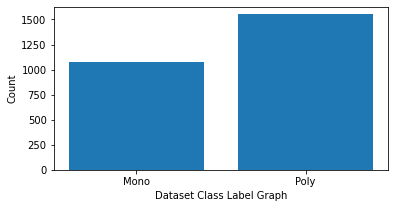

In [5]:
#find and plot images in each class label
unqiue, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize =(6, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

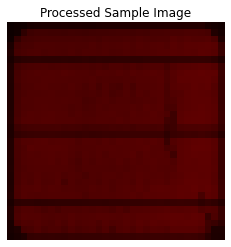

In [6]:
#display sample process image
img = X[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Processed Sample Image')
plt.axis('off')
plt.show()

# preprocess image features and then split dataset into train and test

In [7]:
#
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle image pixels
X = X[indices]
Y = Y[indices]
P = P[indices]
Y = to_categorical(Y)
#split dataset into train and test where 20% dataset size for testing and 80% for testing
split = train_test_split(X, Y, P, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2] #get train and test images
(trainLabels, testLabels) = split[2:4]#get train and test labels
(trainBBoxes, testBBoxes) = split[4:6]#get train bounding boxes as probability
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(trainImages.shape[0])) #print training and test size
print("Testing Size (20%): "+str(testImages.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 2099
Testing Size (20%): 525



Evaluation Metrics

In [8]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []
mAP = []

In [13]:
ML_Model = []
acc = []
prec = []
rec = []
f1 = []
meanap = []
#function to call for storing the results
def storeResults(model, a,b,c,d,e):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))
    meanap.append(round(e, 3))

In [9]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    ma = average_precision_score(testY,predict)*100
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision : '+str(p))
    print(algorithm+' Recall    : '+str(r))
    print(algorithm+' FSCORE    : '+str(f))    
    print(algorithm+' mAP       : '+str(ma))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    mAP.append(ma)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# FasterRCNN 

Faster RCNN Accuracy  : 90.66666666666666
Faster RCNN Precision : 90.08843358725156
Faster RCNN Recall    : 91.80387740816265
Faster RCNN FSCORE    : 90.4668907426005
Faster RCNN mAP       : 92.8699932984599


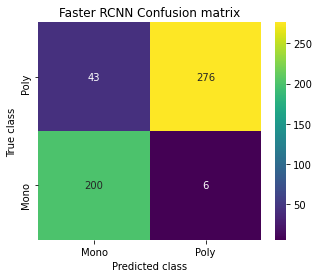

In [10]:
#train existing FRCNN model
#using Resnet50 pretrained model as the base structure for the FasterRCNN
rcnn = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(X.shape[1], X.shape[2], X.shape[3])))
rcnn.trainable = False
#get output
flatten = rcnn.output
#define FRCNN layers by converting multi dimension input features as single dimension
flatten = Flatten()(flatten)
#define FRCNN layer with 16 neurons for features filtration by using flatten
bboxHead = Dense(16, activation="relu")(flatten)
#define layer for bounding box probability
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
#define prediction for bounding boxes
bboxHead = Dense(1, activation="sigmoid", name="bounding_box")(bboxHead)
#define another layer for images training 
softmaxHead = Dense(16, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(8, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
#define classification layer as two classes Mono and Poly
softmaxHead = Dense(2, activation="softmax", name="class_label")(softmaxHead)
frcnn_model = Model(inputs=rcnn.input, outputs=(bboxHead, softmaxHead))
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
opt = Adam(lr=1e-4)
#compile and train the model
frcnn_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
if os.path.exists("model/frcnn.hdf5") == False:
    trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
    testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
    model_check_point = ModelCheckpoint(filepath='model/frcnn.hdf5', verbose = 1, save_best_only = True)
    hist = frcnn_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
    f = open('model/frcnn.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    frcnn_model = load_model('model/frcnn.hdf5')
predict = frcnn_model.predict(testImages)[1]#perform prediction on test data
predict = np.argmax(predict, axis=1)
testY = np.argmax(testLabels, axis=1)
calculateMetrics("Faster RCNN", predict, testY)#call this function to calculate accuracy and other metrics

In [14]:
frcnn_acc = accuracy_score(predict, testY)
frcnn_prec = precision_score(predict, testY,average='macro')
frcnn_rec = recall_score(predict, testY,average='macro')
frcnn_f1 = f1_score(predict, testY,average='macro')
frcnn_map = average_precision_score(predict, testY)

In [28]:
storeResults('Faster RCNN',frcnn_acc[9],frcnn_prec,frcnn_rec,frcnn_f1,frcnn_map)

# YoloV5 with CA attention model

YoloV5 with CA attention model Accuracy  : 97.14285714285714
YoloV5 with CA attention model Precision : 97.63249890754729
YoloV5 with CA attention model Recall    : 96.44520193566059
YoloV5 with CA attention model FSCORE    : 96.9682270191608
YoloV5 with CA attention model mAP       : 95.67334811705398


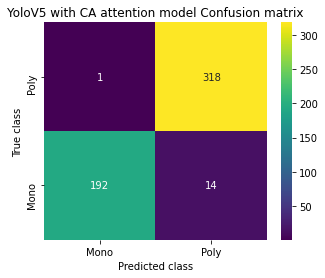

In [16]:
#train propose YoloV5 with CA attention model
#define input shape
input_img = Input(shape=(32, 32, 3))
#create YoloV4 layers with 32, 64 and 512 neurons or data filteration size
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
#adding CA attention layer
x = attention(return_sequences=True,name='attention')(x)#==============adding attention layer
x = Flatten()(x)
#define output layer with 4 bounding box coordinate and 1 weapan class
x = Dense(512, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x_bb = Dense(1, name='bb')(x)
x_class = Dense(2, activation='softmax', name='class')(x)
#create yolo Model with above input details
yolo_model = Model([input_img], [x_bb, x_class])
#compile the model
yolo_model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/yolo_weights.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/yolo_weights.hdf5', verbose = 1, save_best_only = True)
    hist = yolo_model.fit(trainImages, [trainBBoxes, trainLabels], batch_size=32, epochs=10, validation_split=0.2, callbacks=[model_check_point])
    f = open('model/yolo_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    yolo_model = load_model("model/yolo_weights.hdf5", custom_objects={'attention': attention})
predict = yolo_model.predict(testImages)#perform prediction on test data
predict = np.argmax(predict[1], axis=1)
test = np.argmax(testLabels, axis=1)
calculateMetrics("YoloV5 with CA attention model", predict, test)#call this function to calculate accuracy and other metrics

In [17]:
yol_acc = accuracy_score(predict, testY)
yol_prec = precision_score(predict, testY,average='macro')
yol_rec = recall_score(predict, testY,average='macro')
yol_f1 = f1_score(predict, testY,average='macro')
yol_map = average_precision_score(predict, testY)

In [30]:
storeResults('YoloV5 with CA attention model',yol_acc,yol_prec,yol_rec,yol_f1,yol_map)

# YOLOv6 structure by applying VGG16

Extension YoloV6 Accuracy  : 98.28571428571429
Extension YoloV6 Precision : 98.6280487804878
Extension YoloV6 Recall    : 97.81553398058253
Extension YoloV6 FSCORE    : 98.18785691548317
Extension YoloV6 mAP       : 97.2560975609756


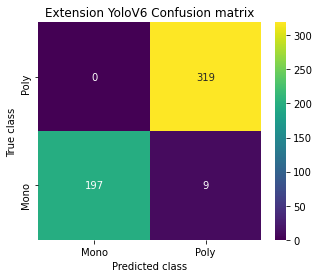

In [18]:
#train Yolov6 as the extension model as this model is the advance version fo Yolov5 and can have more classification
#accuracy compare to propose YOLOV5 with attention
#here we are modifying YOLOv6 structure by applying VGG16 as the base model and then defining Yolov6 architecture
yolov6 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(X.shape[1], X.shape[2], X.shape[3])))
yolov6.trainable = False
#get output of VGG
flatten = yolov6.output
flatten = Flatten()(flatten)
#define new layers of YoloV6
bboxHead = Dense(16, activation="relu")(flatten)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(1, activation="sigmoid", name="bounding_box")(bboxHead)
softmaxHead = Dense(16, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(8, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(2, activation="softmax", name="class_label")(softmaxHead)
#crete yolov6 model
yolov6_model = Model(inputs=yolov6.input, outputs=(bboxHead, softmaxHead))
#define parameters
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
opt = Adam(lr=1e-4)
#compile and train the model
yolov6_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
if os.path.exists("model/yolov6.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/yolov6.hdf5', verbose = 1, save_best_only = True)
    hist = yolov6_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
    f = open('model/yolov6.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    yolov6_model = load_model('model/yolov6.hdf5')
predict = yolov6_model.predict(testImages)[1]#perform prediction on test data
predict = np.argmax(predict, axis=1)
testY = np.argmax(testLabels, axis=1)
calculateMetrics("Extension YoloV6", predict, testY)#call this function to calculate accuracy and other metrics

In [19]:
yol6_acc = accuracy_score(predict, testY)
yol6_prec = precision_score(predict, testY,average='macro')
yol6_rec = recall_score(predict, testY,average='macro')
yol6_f1 = f1_score(predict, testY,average='macro')
yol6_map = average_precision_score(predict, testY)

In [31]:
storeResults('Extension YoloV6',yol6_acc,yol6_prec,yol6_rec,yol6_f1,yol6_map)

In [24]:
yolov6_model.save('model.h5')

# Comparison

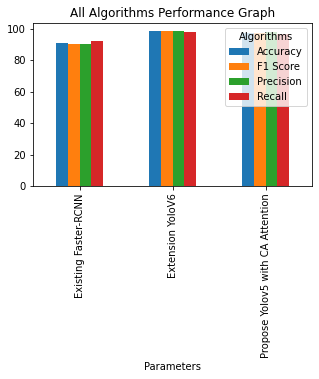

In [20]:
#all algorithm Perfromnace Graph
df = pd.DataFrame([['Existing Faster-RCNN','Precision',precision[0]],['Existing Faster-RCNN','Recall',recall[0]],['Existing Faster-RCNN','F1 Score',fscore[0]],['Existing Faster-RCNN','Accuracy',accuracy[0]],
                   ['Propose Yolov5 with CA Attention','Precision',precision[1]],['Propose Yolov5 with CA Attention','Recall',recall[1]],['Propose Yolov5 with CA Attention','F1 Score',fscore[1]],['Propose Yolov5 with CA Attention','Accuracy',accuracy[1]],
                   ['Extension YoloV6','Precision',precision[2]],['Extension YoloV6','Recall',recall[2]],['Extension YoloV6','F1 Score',fscore[2]],['Extension YoloV6','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize =(5, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [21]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing Faster-RCNN","Propose YoloV5 with CA Attention", "Extension YoloV6"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing Faster-RCNN,90.088434,91.803877,90.466891,90.666667
1,Propose YoloV5 with CA Attention,97.632499,96.445202,96.968227,97.142857
2,Extension YoloV6,98.628049,97.815534,98.187857,98.285714


In [22]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

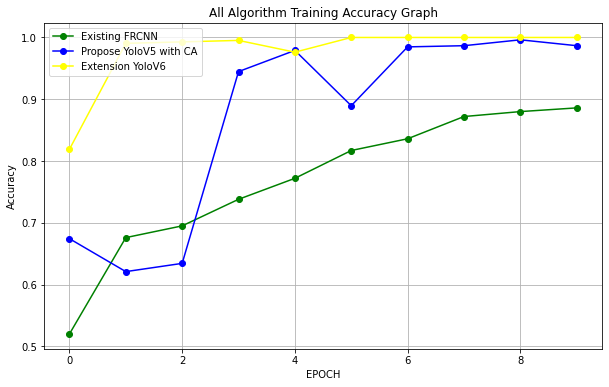

In [23]:
frcnn_acc, frcnn_loss = values("model/frcnn_history.pckl", "accuracy", "loss")
propose_acc, propose_loss = values("model/yolo_history.pckl", "val_class_label_accuracy", "val_loss")
extension_acc, extension_loss = values("model/yolov6.pckl", "val_class_accuracy", "val_loss")
    
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(frcnn_acc, 'ro-', color = 'green')
plt.plot(propose_acc, 'ro-', color = 'blue')
plt.plot(extension_acc, 'ro-', color = 'yellow')
plt.legend(['Existing FRCNN', 'Propose YoloV5 with CA','Extension YoloV6'], loc='upper left')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

In [32]:
classifier = ["Existing Faster-RCNN","Propose YoloV5 with CA Attention", "Extension YoloV6"]
y_pos = np.arange(len(classifier))

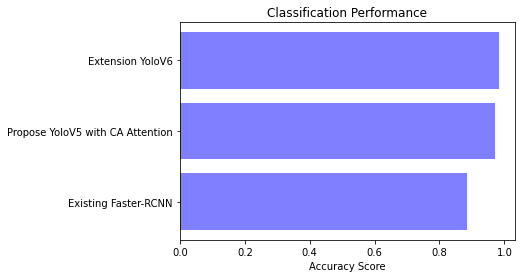

In [33]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

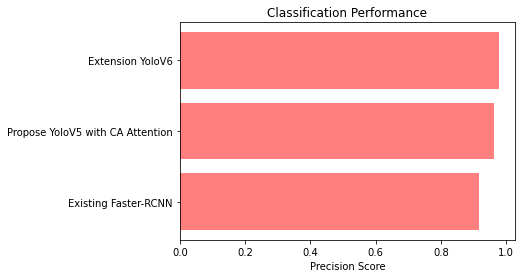

In [34]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

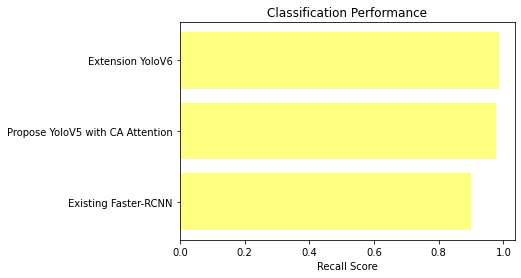

In [35]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

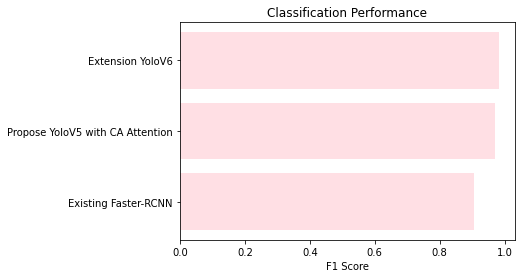

In [36]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

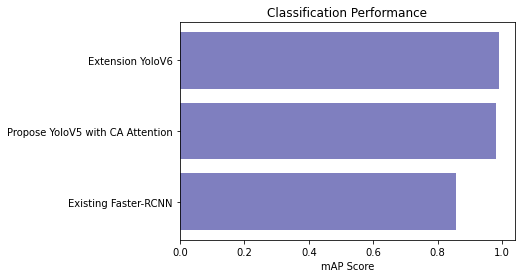

In [37]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, meanap, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('mAP Score')
plt2.title('Classification Performance')
plt2.show()

# Prediction

In [38]:
def predict(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
    img = cv2.flip(img, 1)#flip images
    img = img.reshape(1,32,32,3)#convert image as 4 dimension
    predict = yolov6_model.predict(img)#predict solar defect from test image
    predict_label = predict[1] #get classification defect labels
    defect_probability = predict[0][0][0]#get defect probability
    predict_label = np.argmax(predict_label)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict_label], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.putText(img, 'Defect Probability : '+str(defect_probability), (10, 65),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

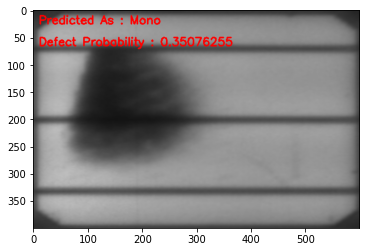

In [39]:
#call this function to detect defect from solar surface
predict("testImages/1.png")

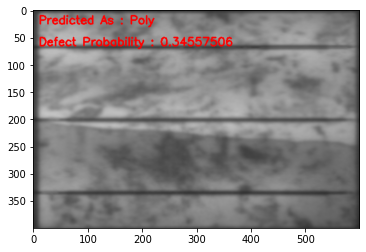

In [40]:
#call this function to detect defect from solar surface
predict("testImages/3.png")

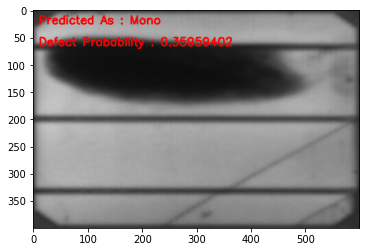

In [41]:
#call this function to detect defect from solar surface
predict("testImages/2.png")

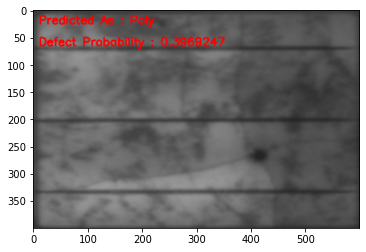

In [42]:
#call this function to detect defect from solar surface
predict("testImages/4.png")

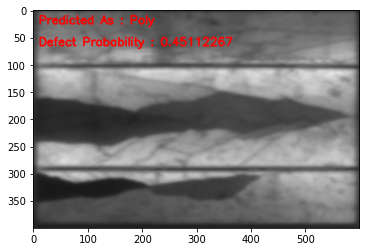

In [43]:
#call this function to detect defect from solar surface
predict("testImages/5.png")

In [44]:
from tensorflow.keras.models import Model, load_model
model = load_model('model.h5')

In [47]:
image_path = "testImages/2.png"

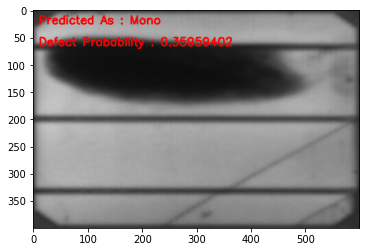

In [48]:
img = cv2.imread(image_path)#read test image
img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
img = cv2.flip(img, 1)#flip images
img = img.reshape(1,32,32,3)#convert image as 4 dimension
predict = model.predict(img)#predict solar defect from test image
predict_label = predict[1] #get classification defect labels
defect_probability = predict[0][0][0]#get defect probability
predict_label = np.argmax(predict_label)
img = cv2.imread(image_path)
img = cv2.resize(img, (600,400))#display image with predicted output
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.putText(img, 'Predicted As : '+labels[predict_label], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
cv2.putText(img, 'Defect Probability : '+str(defect_probability), (10, 65),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
plt.imshow(img)